In [ ]:
import numpy as np

In [ ]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

def dfunc(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:     
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()   
    return grad

def cross_entropy_err(y_hat, y):
    delta = 1e-8
    return -np.sum(y*np.log(y_hat + delta))

In [ ]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
 
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid_function(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax_function(a2)
        return y
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return cross_entropy_err(y_hat, y)
        
    def numerical_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)
        grads = {}
        grads['W1'] = dfunc(loss_W, self.params['W1'])
        grads['b1'] = dfunc(loss_W, self.params['b1'])
        grads['W2'] = dfunc(loss_W, self.params['W2'])
        grads['b2'] = dfunc(loss_W, self.params['b2'])
        return grads

In [ ]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

In [ ]:
net.params['W1']

array([[-0.00999212,  0.00023952,  0.01225109, -0.00578119, -0.00530105],
       [ 0.01837809, -0.0034991 ,  0.00137951, -0.01298947,  0.00884884],
       [-0.01104285,  0.01123044,  0.00848096,  0.00127694,  0.00101045],
       [ 0.00277641,  0.0043066 ,  0.00626061, -0.01373687, -0.00482733]])

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
x= iris.data

In [ ]:
input_x = np.array([[5.1, 3.5, 1.4, 0.2]])
net.predict(input_x)

array([[0.33370794, 0.33434379, 0.33194826]])

In [ ]:
y = np.zeros((len(iris.target), 3))
for idx, val in enumerate(iris.target):
  y[idx, val] = 1

In [ ]:
output_y = np.array([1., 0., 0.])

In [ ]:
net.loss(input_x,output_y)

1.0974890652248435

In [ ]:
import time
epochs = 3000
lr   = 0.01
a = time.clock()
train_loss = []
for i in range(epochs): 
  grad = net.numerical_gradient(x,y)
  for key in ('W1', 'b1', 'W2', 'b2'):
    net.params[key] = net.params[key] - lr * grad[key]
  loss = net.loss(x, y)
  train_loss.append(loss)
print(time.clock() -a )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


21.684755000000003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


## Back Propagation

In [ ]:
class Relu:
  def __init__(self):
    self.cache = None
    
  def forward(self, x):
    self.cache = (x <=0)
    out = np.maximum(0,x)
    return out

  def backward(self, dout):
    dout[self.cache] = 0
    dx = dout
    return dx

In [ ]:
f = Relu()

In [ ]:
x = np.array([-1,1,2])
f.forward(x)

array([0, 1, 2])

In [ ]:
f.cache

array([ True, False, False])

In [ ]:
out = np.array([2,2,2])

In [ ]:
f.backward(out)

array([0, 2, 2])

- https://www.wolframalpha.com/input/?i=derivative+1%2Fx

In [ ]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1/ (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        y  = self.out
        dx = dout * y * (1-y)
        return dx

In [ ]:
s = Sigmoid()

In [ ]:
ary = np.array([-1,1,2])
s.forward(ary)

array([0.26894142, 0.73105858, 0.88079708])

In [ ]:
out = np.array([2,2,2])
s.backward(out)

array([0.39322387, 0.39322387, 0.20998717])

In [ ]:
2 * 0.26894142 * (1- 0.26894142)

0.39322386521676717

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout)
        return dx

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y_hat = None 
        self.y = None 

    def forward(self, x, y):
        self.y = y
        self.y_hat = softmax_function(x)
        self.loss = cross_entropy_err(self.y_hat, self.y)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        dx = (self.y_hat - self.y) / batch_size
        return dx

In [ ]:
import numpy as np
from collections import OrderedDict

class ANN:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return self.lastLayer.forward(y_hat, y)
  
    def gradient(self, x, y):
        # forward
        self.loss(x, y)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [ ]:
import random
import time

epochs     = 3000
lr         = 0.01
batch_size = 30

net = ANN(input_size=4, hidden_size=5, output_size=3)

t0 = time.clock()
train_loss = []
for i in range(epochs): 
    idx = np.random.choice(iris.data.shape[0], batch_size)
    x_batch   = iris.data[idx]
    y_batch   = y[idx]
    grad = net.gradient(x_batch,y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] -= lr * grad[key]
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)
    
time.clock() - t0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.5818330000000032

### Scikit Learn

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

In [ ]:
import numpy as np
s = np.array([0,10,20,30,50,100,200])
s

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

s2 = sigmoid_function(s)
s2

array([0.5      , 0.9999546, 1.       , 1.       , 1.       , 1.       ,
       1.       ])

In [ ]:
# (x - mu) / std
s_ = (s - s.mean()) / s.std()
s2_ = sigmoid_function(s_)
s2_

array([0.28979036, 0.32227026, 0.35656286, 0.39239179, 0.46725174,
       0.65340512, 0.8970145 ])

In [ ]:
s_

array([-0.89640241, -0.7433581 , -0.59031378, -0.43726947, -0.13118084,
        0.63404073,  2.16448387])

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
s.reshape(-1, 1)


array([[  0],
       [ 10],
       [ 20],
       [ 30],
       [ 50],
       [100],
       [200]])

In [ ]:
sc.fit_transform(s.reshape(-1, 1))

array([[-0.89640241],
       [-0.7433581 ],
       [-0.59031378],
       [-0.43726947],
       [-0.13118084],
       [ 0.63404073],
       [ 2.16448387]])

In [ ]:
# fit : generate mean, std
# transform: transform data
# fit_transform: generate mean, std, then transform data

In [ ]:
sc.mean_, sc.var_

(array([58.57142857]), array([4269.3877551]))

In [ ]:
sc = StandardScaler()
X = sc.fit_transform(iris.data)
y = iris.target

In [ ]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
f# 4 -> 5 -> 3
from sklearn.neural_network import MLPClassifier
#?MLPClassifier
clf = MLPClassifier( hidden_layer_sizes =(5,) , activation = 'logistic', solver  = 'sgd', max_iter = 3000)
clf.fit(X,y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=3000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
pred_y = clf.predict(X)

In [ ]:
(y == pred_y).sum() / len(pred_y)

0.8866666666666667

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y, pred_y)

0.8866666666666667

In [ ]:
confusion_matrix(y, pred_y)

array([[50,  0,  0],
       [ 0, 34, 16],
       [ 0,  1, 49]])

In [ ]:
from sklearn.neural_network import MLPClassifier
#?MLPClassifier
clf = MLPClassifier( hidden_layer_sizes =(5,) , solver  = 'sgd', max_iter = 10000)
clf.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred_y = clf.predict(X)
accuracy_score(y, pred_y)

0.9533333333333334

## MNIST Problem

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

In [ ]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [ ]:
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [ ]:
digits.data.shape

(1797, 64)

In [ ]:
digits.images.shape

(1797, 8, 8)

In [ ]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

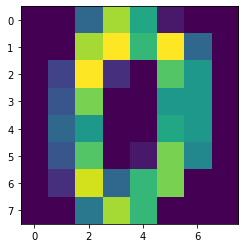

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(digits.images[0])

In [ ]:
digits.target[0]

0

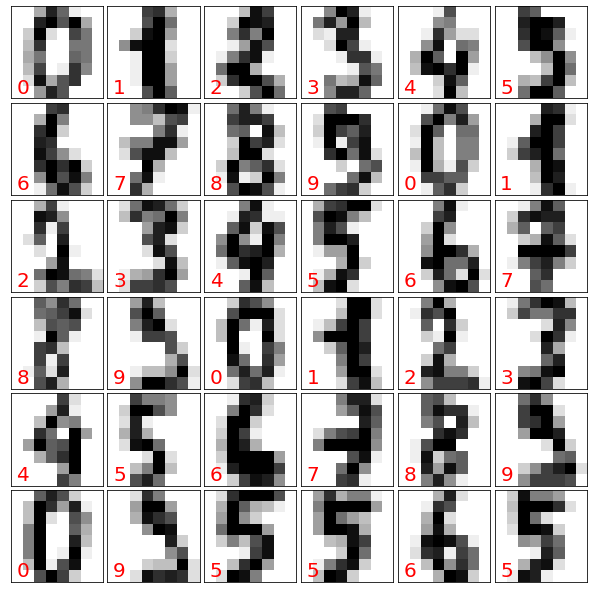

In [ ]:
fig = plt.figure(figsize = (8,8))

# 圖與圖的間距
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# 取樣36 張圖
for i in range(36):
    # 每張 6 * 6 的大小
    ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
    # 繪製灰階圖
    ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
    # 於左下標示紅色大小為20數字
    ax.text(0, 7, digits.target[i], color="r", fontsize = 20)

In [ ]:
digits.data.shape

(1797, 64)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaled = sc.fit_transform(digits.data)

In [ ]:
X_scaled

array([[ 0.        , -0.33501649, -0.04308102, ..., -1.14664746,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  0.54856067,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -1.09493684, ...,  1.56568555,
         1.6951369 , -0.19600752],
       ...,
       [ 0.        , -0.33501649, -0.88456568, ..., -0.12952258,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649, -0.67419451, ...,  0.8876023 ,
        -0.5056698 , -0.19600752],
       [ 0.        , -0.33501649,  1.00877481, ...,  0.8876023 ,
        -0.26113572, -0.19600752]])

In [ ]:
# 64 -> 30 -> 10
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( hidden_layer_sizes =(30,30,30,) , solver  = 'sgd', max_iter = 1000)
clf.fit(X_scaled,digits.target)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
predicted = clf.predict(X_scaled)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(digits.target, predicted)

0.9977740678909294

In [ ]:
confusion_matrix(digits.target, predicted)

array([[178,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 182,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 177,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 182,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0, 181,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 181,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 181,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 179,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0, 173,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1, 179]])

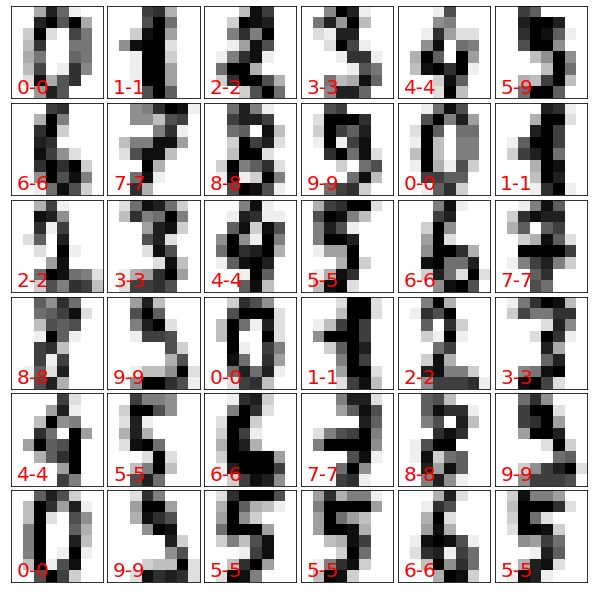

In [ ]:
fig = plt.figure(figsize = (8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(36):
  ax = fig.add_subplot(6, 6, i+1, xticks=[], yticks=[])
  ax.imshow(digits.images[i],cmap=plt.cm.binary,interpolation='nearest')
  ax.text(0, 7, '{}-{}'.format(digits.target[i],predicted[i]), color="red", fontsize = 20)


In [ ]:
clf.coefs_[0]

array([[-0.05432784,  0.0030218 ,  0.04502747, ..., -0.15130056,
         0.14419791,  0.19474398],
       [ 0.02953598,  0.0697499 , -0.1958164 , ..., -0.12245734,
        -0.0390427 , -0.12123463],
       [-0.2564587 , -0.08997708, -0.2450324 , ...,  0.21821492,
         0.00317387, -0.0852212 ],
       ...,
       [ 0.20451573,  0.21510141, -0.13630205, ..., -0.06248469,
        -0.23862207, -0.50718221],
       [ 0.01988876,  0.18999365, -0.25286742, ..., -0.29982016,
        -0.22370142, -0.17642451],
       [-0.13111792, -0.03962111,  0.06630459, ..., -0.04402813,
         0.05438185,  0.0707858 ]])

In [ ]:
clf.coefs_[0].shape

(64, 30)

In [ ]:
! wget https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/unknown_digits.bmp

--2021-03-27 03:29:28--  https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/unknown_digits.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150 [image/bmp]
Saving to: ‘unknown_digits.bmp’

unknown_digits.bmp  100%[===================>]     150  --.-KB/s    in 0s      

2021-03-27 03:29:29 (4.04 MB/s) - ‘unknown_digits.bmp’ saved [150/150]



In [ ]:
from PIL import Image
Image.open('unknown_digits.bmp')

In [ ]:
im = np.array(Image.open('unknown_digits.bmp'))

In [ ]:
im

array([[15, 15, 15, 15, 15, 15, 15, 15],
       [15, 15,  0, 15,  0, 15, 15, 15],
       [15, 15,  0, 15,  0, 15, 15, 15],
       [15,  0,  0, 15,  0, 15, 15, 15],
       [15,  0, 15, 15,  0, 15, 15, 15],
       [ 0,  0,  0,  0,  0,  0,  0, 15],
       [15, 15, 15, 15,  0, 15, 15, 15],
       [15, 15, 15, 15,  0, 15, 15, 15]], dtype=uint8)

In [ ]:
15 - im

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 15,  0, 15,  0,  0,  0],
       [ 0,  0, 15,  0, 15,  0,  0,  0],
       [ 0, 15, 15,  0, 15,  0,  0,  0],
       [ 0, 15,  0,  0, 15,  0,  0,  0],
       [15, 15, 15, 15, 15, 15, 15,  0],
       [ 0,  0,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  0,  0,  0]], dtype=uint8)

In [ ]:
im2 = (15 - im).reshape(64,)

In [ ]:
im2

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0, 15,  0,  0,  0,  0,
        0, 15,  0, 15,  0,  0,  0,  0, 15, 15,  0, 15,  0,  0,  0,  0, 15,
        0,  0, 15,  0,  0,  0, 15, 15, 15, 15, 15, 15, 15,  0,  0,  0,  0,
        0, 15,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0], dtype=uint8)

In [ ]:
src = sc.transform([im2])

In [ ]:
src

array([[ 0.00000000e+00, -3.35016487e-01, -1.09493684e+00,
        -2.78643746e+00, -2.76424203e+00, -1.02065685e+00,
        -4.09723921e-01, -1.25022923e-01, -5.90775571e-02,
        -6.24009262e-01,  8.51981802e-01, -3.01259995e+00,
         9.87303977e-01, -1.35109507e+00, -5.14991458e-01,
        -1.30433381e-01, -4.46250733e-02, -7.27646281e-01,
         8.95880438e-01, -1.20543167e+00,  1.27989088e+00,
        -1.25998248e+00, -5.48805463e-01, -1.14221844e-01,
        -3.33797263e-02,  3.98337420e+00,  9.54513151e-01,
        -1.49990136e+00,  8.24810596e-01, -1.28625035e+00,
        -6.28895882e-01, -4.72323823e-02,  0.00000000e+00,
         3.63871114e+00, -1.21260656e+00, -1.44763006e+00,
         7.92062324e-01, -1.48986148e+00, -8.22694515e-01,
         0.00000000e+00,  1.03283569e+02,  4.50060728e+00,
         1.24209958e+00,  1.20688552e+00,  1.17098727e+00,
         1.18784054e+00,  2.66613420e+00, -8.87416172e-02,
        -3.54332626e-02, -4.03574986e-01, -1.33033057e+0

In [ ]:
clf.predict(src)

array([4])

In [ ]:
import pickle
with open('model.pickle', 'wb') as f:
  f.write(pickle.dumps(clf))   

In [ ]:
import pickle
clf2 = pickle.loads(open('model.pickle', 'rb').read())

In [ ]:
clf2.predict(src)

array([4])

In [ ]:
from flask import Flask,jsonify,request
import pickle

app=Flask(__name__)

clf2 = pickle.loads(open('model.pickle', 'rb').read())

@app.route("/detect/", methods=['POST'])
def getDigit():
  if request.method=='POST':
    data =request.values['data']
    print(data)
    return jsonify({'data' : str(clf2.predict(data)[0]) })
  
if __name__=="__main__":
	app.run()
		
		

In [ ]:
print(src.tolist())

[[0.0, -0.3350164872543856, -1.094936844017646, -2.786437463717163, -2.7642420323439483, -1.020656851707342, -0.40972392088346243, -0.1250229232970408, -0.05907755711884675, -0.6240092623290964, 0.8519818016140983, -3.0125999462748765, 0.9873039771441071, -1.3510950695628445, -0.5149914578404, -0.13043338063115095, -0.04462507326885248, -0.7276462807767011, 0.8958804382797294, -1.2054316703500525, 1.2798908768852115, -1.2599824810387747, -0.5488054634350632, -0.11422184388584329, -0.03337972630405602, 3.9833742019110137, 0.9545131508749777, -1.4999013596489101, 0.8248105963072385, -1.2862503540232368, -0.6288958824871538, -0.047232382286089766, 0.0, 3.63871113826685, -1.2126065616315402, -1.4476300608538812, 0.7920623240574896, -1.4898614841433477, -0.8226945146290309, 0.0, 103.28356854496502, 4.500607278976236, 1.2420995782028617, 1.206885522239877, 1.1709872746098737, 1.1878405437695074, 2.6661342009456024, -0.08874161717060432, -0.035433262605025426, -0.4035749858171405, -1.33033056

In [ ]:
import requests
payload = {
 'data':[0.0, -0.3350164872543856, -1.094936844017646, -2.786437463717163, -2.7642420323439483, -1.020656851707342, -0.40972392088346243, -0.1250229232970408, -0.05907755711884675, -0.6240092623290964, 0.8519818016140983, -3.0125999462748765, 0.9873039771441071, -1.3510950695628445, -0.5149914578404, -0.13043338063115095, -0.04462507326885248, -0.7276462807767011, 0.8958804382797294, -1.2054316703500525, 1.2798908768852115, -1.2599824810387747, -0.5488054634350632, -0.11422184388584329, -0.03337972630405602, 3.9833742019110137, 0.9545131508749777, -1.4999013596489101, 0.8248105963072385, -1.2862503540232368, -0.6288958824871538, -0.047232382286089766, 0.0, 3.63871113826685, -1.2126065616315402, -1.4476300608538812, 0.7920623240574896, -1.4898614841433477, -0.8226945146290309, 0.0, 103.28356854496502, 4.500607278976236, 1.2420995782028617, 1.206885522239877, 1.1709872746098737, 1.1878405437695074, 2.6661342009456024, -0.08874161717060432, -0.035433262605025426, -0.4035749858171405, -1.3303305692353373, -1.8255180497959467, 1.053423974798085, -1.452611516733505, -0.757435809805409, -0.2097851269640334, -0.023596458909150665, -0.2990813468001315, -1.0893830867486862, -2.764171010227604, 0.6468982447538705, -1.1466474561031994, -0.5056698025808581, -0.1960075186604789]    
}
res = requests.post('http://127.0.0.1:5000/detect/', data = payload)
print(res.json())

## Gradient Vanishing

In [128]:
def sigmoid_function(x):
  return 1 / (1 +np.exp(-x))

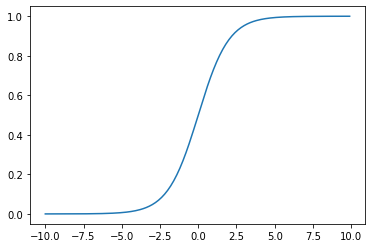

In [129]:
from matplotlib import pyplot as plt
import numpy as np
x = np.arange(-10,10,0.1)
y = sigmoid_function(x)
plt.plot(x,y)

In [130]:
def dfunc(f, x):
  h = 1e-4
  return (f(x+h) - f(x-h)) / (2*h)

In [131]:
d_y = dfunc(sigmoid_function,x )

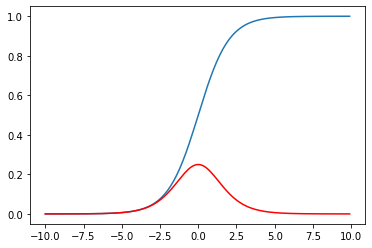

In [132]:
from matplotlib import pyplot as plt
import numpy as np
x = np.arange(-10,10,0.1)
y = sigmoid_function(x)
d_y = dfunc(sigmoid_function,x )
plt.plot(x,y)
plt.plot(x,d_y, c = 'red')

##ＳＶＭ

In [133]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [136]:
iris = load_iris()
X = iris.data[0:100,[2,3]]
y = iris.target[0:100]

clf1 = SVC(kernel="linear")
clf1.fit(X, y)

clf2 = LogisticRegression()
clf2.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:

def plot_estimator(estimator, X, y):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
  np.arange(y_min, y_max, 0.1))
  Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.plot()
  plt.contourf(xx, yy, Z, alpha=0.4, cmap = plt.cm.RdYlBu)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.brg)
  plt.xlabel('Petal.Length')
  plt.ylabel('Petal.Width')
  plt.show()

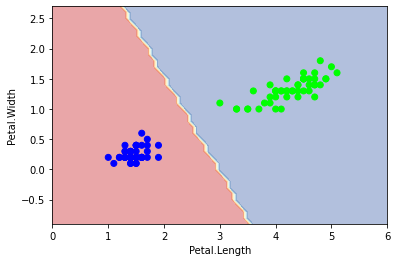

In [139]:
plot_estimator(clf1, X, ｙ)

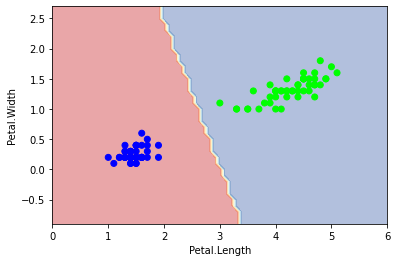

In [142]:
plot_estimator(clf2, X, y)

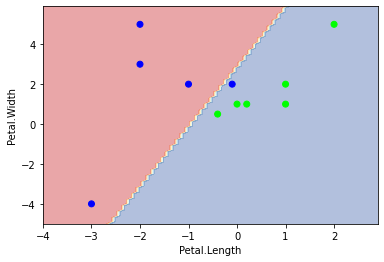

In [143]:
data = np.array([[-1,2,0],[-2,3,0],[-2,5,0],[-3,-4,0],[-0.1,2,0],[0.2,1,1],[0,1,1],[1,2,1], [1,1,1], [-
0.4,0.5,1],[2,5,1]])

X = data[:, :2]
Y = data[:,2]

# Large Margin
clf = SVC(C=1.0, kernel='linear')
clf.fit(X, Y)

plot_estimator(clf,X,Y)

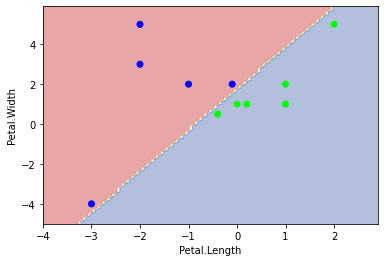

In [144]:
# Narrow Margin
clf = SVC(C=100000, kernel='linear')
clf.fit(X, Y)
plot_estimator(clf,X,Y)

In [146]:

iris = load_iris()
X = iris.data[:,[2,3]]
y = iris.target

In [147]:
clf1 = SVC(kernel="rbf", random_state = 123)
clf1.fit(X, y)

clf2 = SVC(kernel="poly")
clf2.fit(X, y)

clf3 = SVC(kernel="linear")
clf3.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

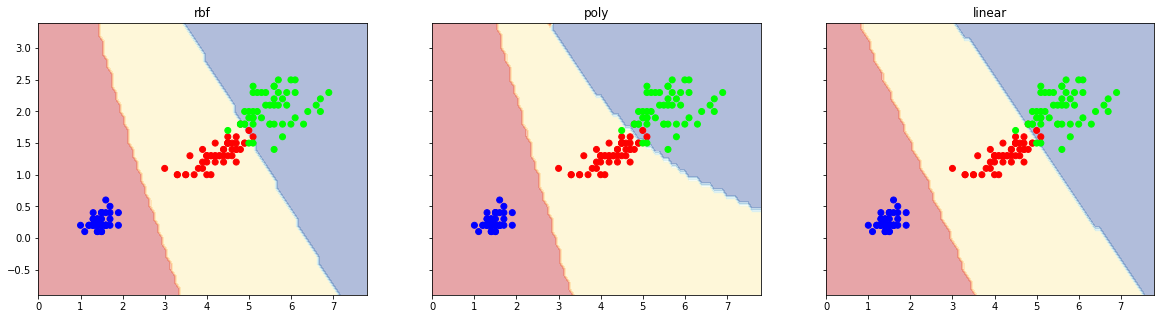

In [148]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20, 5))

for idx, clf, title in zip([0,1,2],[clf1, clf2, clf3], ['rbf', 'poly', 'linear']):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  axarr[idx].contourf(xx, yy, Z, alpha=0.4, cmap = plt.cm.RdYlBu)
  axarr[idx].scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.brg)
  axarr[idx].set_title(title)

## Tensorflow

In [151]:
import tensorflow

In [152]:
tensorflow.__version__

'2.4.1'

In [153]:
from tensorflow import keras
keras.__version__

'2.4.0'

## Keras On MNIST 

In [154]:
from tensorflow import keras
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [155]:
x_train.shape

(60000, 28, 28)

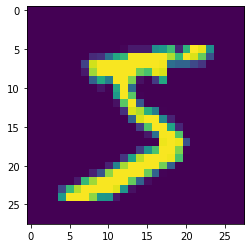

In [157]:
from matplotlib import pyplot as plt
plt.imshow(x_train[0])

In [158]:
y_train[0]

5

In [159]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [160]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [161]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [167]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
# Dense: x * w + b
model.add(Dense(256, activation = 'relu', input_shape = (784,)))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10))

In [168]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [169]:
# categorical crossentropy => [1,0,0]
# SparseCategoricalCrossentropy => 0

from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='sgd',
       loss=loss_fn,
       metrics=['accuracy'])

In [170]:
model.fit(x_train, y_train, 
    epochs=15, batch_size = 256,
    validation_data = (x_test, y_test))

Epoch 1/15
235/235 [==============================] - 3s 11ms/step - loss: 1.9894 - accuracy: 0.4140 - val_loss: 1.0063 - val_accuracy: 0.7923
Epoch 2/15
235/235 [==============================] - 2s 10ms/step - loss: 0.8813 - accuracy: 0.8047 - val_loss: 0.5863 - val_accuracy: 0.8593
Epoch 3/15
235/235 [==============================] - 2s 10ms/step - loss: 0.5608 - accuracy: 0.8600 - val_loss: 0.4556 - val_accuracy: 0.8821
Epoch 4/15
235/235 [==============================] - 2s 10ms/step - loss: 0.4541 - accuracy: 0.8817 - val_loss: 0.3908 - val_accuracy: 0.8964
Epoch 5/15
235/235 [==============================] - 2s 10ms/step - loss: 0.3988 - accuracy: 0.8921 - val_loss: 0.3561 - val_accuracy: 0.9020
Epoch 6/15
235/235 [==============================] - 2s 10ms/step - loss: 0.3655 - accuracy: 0.8987 - val_loss: 0.3307 - val_accuracy: 0.9102
Epoch 7/15
235/235 [==============================] - 2s 10ms/step - loss: 0.3360 - accuracy: 0.9061 - val_loss: 0.3141 - val_accuracy: 0.9130

In [191]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
# Dense: x * w + b
model.add(Dense(256, activation = 'relu', input_shape = (784,)))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(10, activation='softmax'))

In [192]:
from tensorflow.keras import utils
y_train_ = utils.to_categorical(y_train, 10)

In [193]:
y_train_.shape

(60000, 10)

In [194]:
y_test_ = utils.to_categorical(y_test, 10)

In [195]:
model.compile(optimizer='sgd',
       loss='categorical_crossentropy',
       metrics=['accuracy'])

In [196]:
model.fit(x_train, y_train_, 
    epochs=15, batch_size = 256,
    validation_data = (x_test, y_test_))

Epoch 1/15
235/235 [==============================] - 3s 11ms/step - loss: 1.9993 - accuracy: 0.4283 - val_loss: 0.9823 - val_accuracy: 0.8194
Epoch 2/15
235/235 [==============================] - 2s 10ms/step - loss: 0.8469 - accuracy: 0.8292 - val_loss: 0.5413 - val_accuracy: 0.8730
Epoch 3/15
235/235 [==============================] - 2s 10ms/step - loss: 0.5264 - accuracy: 0.8707 - val_loss: 0.4258 - val_accuracy: 0.8902
Epoch 4/15
235/235 [==============================] - 2s 10ms/step - loss: 0.4365 - accuracy: 0.8845 - val_loss: 0.3770 - val_accuracy: 0.8985
Epoch 5/15
235/235 [==============================] - 2s 10ms/step - loss: 0.3875 - accuracy: 0.8933 - val_loss: 0.3452 - val_accuracy: 0.9061
Epoch 6/15
235/235 [==============================] - 2s 10ms/step - loss: 0.3564 - accuracy: 0.9005 - val_loss: 0.3223 - val_accuracy: 0.9101
Epoch 7/15
235/235 [==============================] - 2s 10ms/step - loss: 0.3406 - accuracy: 0.9045 - val_loss: 0.3069 - val_accuracy: 0.9146

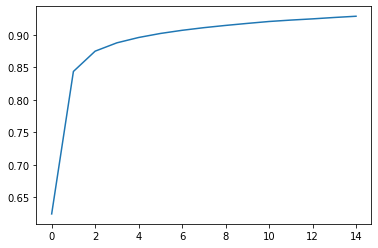

In [197]:
plt.plot(range(len(model.history.history['accuracy'])), model.history.history['accuracy'])

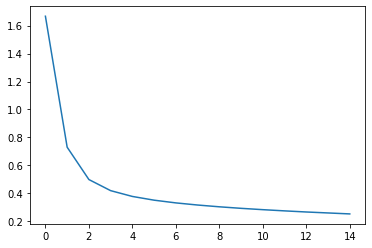

In [198]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [199]:
model.save('model.h5')

In [200]:
from tensorflow.keras.models import load_model
model2 = load_model('model.h5')

In [ ]:
! cp model.h5 /content/drive/MyDrive/

## Pandas

In [201]:
import numpy as np
a = [1,2,3,4,5]
na = np.array(a)
na.mean()

3.0

In [202]:
persons = np.array([['David', 30, 'Taipei'], ['John', 40, 'Chiayi'], ['Mary',18, 'Taipei']])

In [206]:
#persons[:,1].mean()

In [207]:
import pandas
persons_df = pandas.DataFrame([['David', 30, 'Taipei'], ['John', 40, 'Chiayi'], ['Mary',18, 'Taipei']], columns = ['name', 'age', 'address'])

In [208]:
persons_df

,name,age,address
0,David,30,Taipei
1,John,40,Chiayi
2,Mary,18,Taipei


In [210]:
persons_df['age'].mean()

29.333333333333332

## Churn Analysis

### Data Loading

In [211]:
import pandas
df = pandas.read_csv('https://github.com/ywchiu/tibamedl/raw/master/Data/customer_churn.csv', index_col=0)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


### Data Cleansing

In [213]:
df.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [214]:
# 去除前三欄
df = df.iloc[:,3:]
df.head()

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 1 to 3333
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   international_plan             3333 non-null   object 
 1   voice_mail_plan                3333 non-null   object 
 2   number_vmail_messages          3333 non-null   int64  
 3   total_day_minutes              3333 non-null   float64
 4   total_day_calls                3333 non-null   int64  
 5   total_day_charge               3333 non-null   float64
 6   total_eve_minutes              3333 non-null   float64
 7   total_eve_calls                3333 non-null   int64  
 8   total_eve_charge               3333 non-null   float64
 9   total_night_minutes            3333 non-null   float64
 10  total_night_calls              3333 non-null   int64  
 11  total_night_charge             3333 non-null   float64
 12  total_intl_minutes             3333 non-null   f

In [216]:
df.select_dtypes('object').head()

,international_plan,voice_mail_plan,churn
1,no,yes,no
2,no,yes,no
3,no,no,no
4,yes,no,no
5,yes,no,no


In [218]:
df['international_plan'].unique()

array(['no', 'yes'], dtype=object)

In [219]:
df['voice_mail_plan'].unique()

array(['yes', 'no'], dtype=object)

In [220]:
df['churn'].unique()

array(['no', 'yes'], dtype=object)

In [221]:
df['international_plan'] = df['international_plan'].replace({'yes':1, 'no':0})

In [223]:
import pandas
df2 = pandas.DataFrame([{'city': 'Taipei'},{'city': 'Tainan'},{'city': 'Chiayi'},{'city': 'Taipei'}])
# get dummies = '創造虛擬變量' = 'one hot encoding'
pandas.get_dummies(df2['city'])

,Chiayi,Tainan,Taipei
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1


In [224]:
df['voice_mail_plan'] = df['voice_mail_plan'].replace({'yes':1, 'no':0})

In [225]:
df['churn'] = df['churn'].replace({'yes':1, 'no':0})

In [226]:
df.head()

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
2,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
3,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
4,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
5,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [227]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [229]:
X.shape

(3333, 16)

In [230]:
y.shape

(3333,)

In [231]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 0.33, random_state = 42)

### Data Standardization

In [232]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

In [235]:
train_X.shape

(2233, 16)

In [236]:
test_X.shape

(1100, 16)

### Training Model

In [284]:
# 16 -> 8 -> 1 (sigmoid)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(8, activation = 'relu', input_shape = (16,)))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [285]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


In [286]:
model.compile(optimizer='sgd',
       loss='binary_crossentropy',
       metrics=['accuracy'])

In [297]:
history = model.fit(
 train_X, train_y,
 epochs = 100,
 batch_size = 32,
 verbose = 0,
 validation_data = (test_X, test_y)   

)

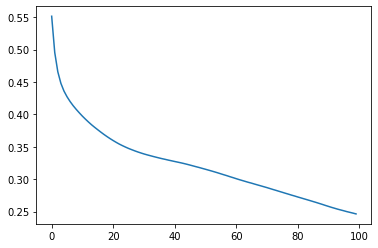

In [288]:
from matplotlib import pyplot as plt
plt.plot(range(len(history.history.get('loss'))), history.history.get('loss'))

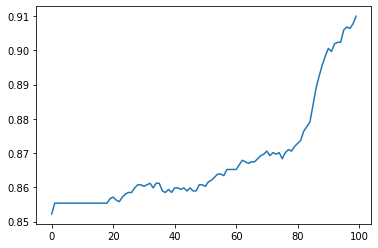

In [289]:
plt.plot(range(len(history.history.get('accuracy'))), history.history.get('accuracy'))

## Evalute

In [298]:
model.evaluate(test_X, test_y)

35/35 [==============================] - 0s 987us/step - loss: 0.2224 - accuracy: 0.9164


[0.22236116230487823, 0.9163636565208435]

In [299]:
model.predict(test_X)

array([[0.05274206],
       [0.005564  ],
       [0.8484011 ],
       ...,
       [0.0204789 ],
       [0.8170843 ],
       [0.13950828]], dtype=float32)

In [300]:
pred_y = (model.predict(test_X) > 0.5).flatten().astype(int)

In [301]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(test_y, pred_y)

0.9163636363636364

In [302]:
test_y.value_counts()

0    940
1    160
Name: churn, dtype: int64

In [303]:
1 - (160 / 1100)

0.8545454545454545

In [304]:
confusion_matrix(test_y, pred_y)

array([[917,  23],
       [ 69,  91]])

In [306]:
from sklearn.metrics import classification_report
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       940
           1       0.80      0.57      0.66       160

    accuracy                           0.92      1100
   macro avg       0.86      0.77      0.81      1100
weighted avg       0.91      0.92      0.91      1100



## Optimizer

In [308]:
def tarinProcess(optimizer):
  model = Sequential()
  model.add(Dense(units = 8, activation = 'relu', input_dim = 16))
  model.add(Dense(units = 1,activation = 'sigmoid'))
  model.compile(loss='binary_crossentropy',
         optimizer=optimizer,
         metrics=['accuracy'])

  history = model.fit(train_X,train_y,
            batch_size=30,
            epochs=100,
            verbose=0,
            )
  return history

In [309]:
sgd_history = tarinProcess('sgd')

In [310]:
rmsprop_history = tarinProcess('RMSprop')

In [311]:
adagrad_history = tarinProcess('Adagrad')

In [312]:
adadelta_history = tarinProcess('Adadelta')

In [313]:
adam_history = tarinProcess('Adam')

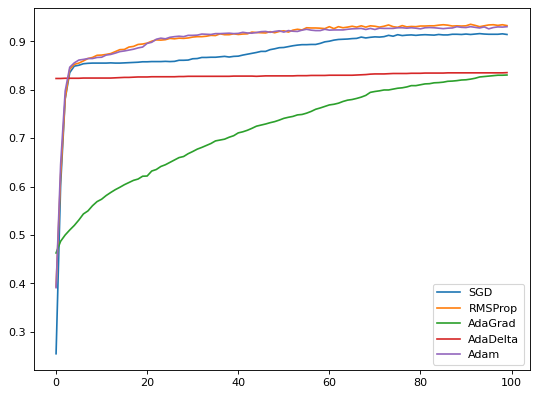

In [314]:
import matplotlib.pyplot as plt
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(sgd_history.epoch, sgd_history.history.get('accuracy'), label='SGD')
plt.plot(rmsprop_history.epoch, rmsprop_history.history.get('accuracy'), label='RMSProp')
plt.plot(adagrad_history.epoch, adagrad_history.history.get('accuracy'), label='AdaGrad')
plt.plot(adadelta_history.epoch, adadelta_history.history.get('accuracy'), label='AdaDelta')
plt.plot(adam_history.epoch, adam_history.history.get('accuracy'), label='Adam')

plt.legend()
plt.show()

## 作業
目標: 建立一深度學習模型預測客戶是否流失

- 問題1: 利用df 產生 X,y
- 問題2: 請將資料區分為訓練與測試資料集
- 問題3: 請將資料標準化
- 問題4: 使用Keras 建立深度學習模型預測客戶是否流失
- 問題5: 評估模型準確度

In [315]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/Churn_Modelling.csv', header = 0 )
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Data Preprocessing
- Structural Data 
- No Missing Value
- All data are numeric

In [316]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [318]:
df = df.iloc[:,3:]

In [319]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [321]:
df.select_dtypes('object').head()

,Geography,Gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female


In [322]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [323]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [325]:
geo = pandas.get_dummies(df['Geography'])
geo.head()
del geo['France']
geo.head()

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1


In [327]:
df['Gender'] = df['Gender'].replace({'Male':1, 'Female': 0})

In [330]:
df = pandas.concat([geo, df], axis = 1)
df.head()

,Germany,Spain,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,0,1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,0,0,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,0,0,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,0,1,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


In [332]:
del df['Geography']

In [333]:
df.head()

,Germany,Spain,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,0,619,0,42,2,0.00,1,1,1,101348.88,1
1,0,1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,0,0,502,0,42,8,159660.80,3,1,0,113931.57,1
3,0,0,699,0,39,1,0.00,2,0,0,93826.63,0
4,0,1,850,0,43,2,125510.82,1,1,1,79084.10,0
